!pip install wordcloud #Install it if needed

!pip install nltk

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import t_min_prj_lib as prjlib # Project Lib

# 1. EDA

## 1.1 Loading Datasets 

Datasets are comma delimiter csv's but we found out that there are commas in train.csv "text" inside the "text" field. Anyway, using Pandas PD, the issue was resolved. 

In [35]:
ds_train = pd.read_csv("train.csv")

In [36]:
ds_train.head()

text  label
0  $BYND - JPMorgan reels in expectations on Beyo...      0
1  $CCL $RCL - Nomura points to bookings weakness...      0
2  $CX - Cemex cut at Credit Suisse, J.P. Morgan ...      0
3  $ESS: BTIG Research cuts to Neutral https://t....      0
4  $FNKO - Funko slides after Piper Jaffray PT cu...      0

In [37]:
ds_train['label'].value_counts()

label
2    6178
1    1923
0    1442
Name: count, dtype: int64

In [38]:
ds_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9543 entries, 0 to 9542
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    9543 non-null   object
 1   label   9543 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 149.2+ KB


#### Loading and checking test.csv too

In [39]:
ds_test = pd.read_csv("test.csv")

In [40]:
ds_test.head(5)

id                                               text
0   0  ETF assets to surge tenfold in 10 years to $50...
1   1  Here’s What Hedge Funds Think Evolution Petrol...
2   2  $PVH - Phillips-Van Heusen Q3 2020 Earnings Pr...
3   3  China is in the process of waiving retaliatory...
4   4  Highlight: “When growth is scarce, investors s...

## 1.2 Train Dataset Distribution

#### Plotting train dataset distribution

In [41]:
ds_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2388 entries, 0 to 2387
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2388 non-null   int64 
 1   text    2388 non-null   object
dtypes: int64(1), object(1)
memory usage: 37.4+ KB


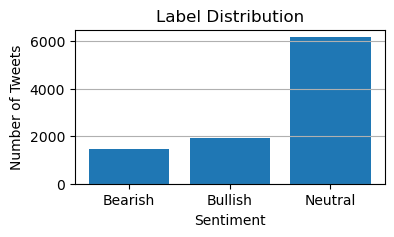

In [42]:
label_counts = ds_train["label"].value_counts().sort_index()
label_names = {0: "Bearish", 1: "Bullish", 2: "Neutral"}

plt.figure(figsize=(4, 2))
plt.bar(label_names.values(), label_counts)
plt.title("Label Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Number of Tweets")
plt.grid(axis="y")
plt.show()


» train.csv is very imbalanced, with huge <b>Neural</b> predomination over <b>Bearish</b> and <b>Bullisth</b>.  

Due to strong class imbalance, we will apply class_weight='balanced' during model training and evaluate performance using macro-averaged precision, recall, and F1-score. For traditional models, we will also experiment with oversampling the minority classes.

## 1.3 Clean text procedures

#### Basic pre-processing with "eda_clean_text" (project lib)

In [43]:
ds_train["clean_text"] = ds_train["text"].apply(prjlib.eda_clean_text)

In [44]:
ds_train["clean_text"].head()

0        jpmorgan reels in expectations on beyond meat
1    nomura points to bookings weakness at carnival...
2    cemex cut at credit suisse jp morgan on weak b...
3                        btig research cuts to neutral
4              funko slides after piper jaffray pt cut
Name: clean_text, dtype: object

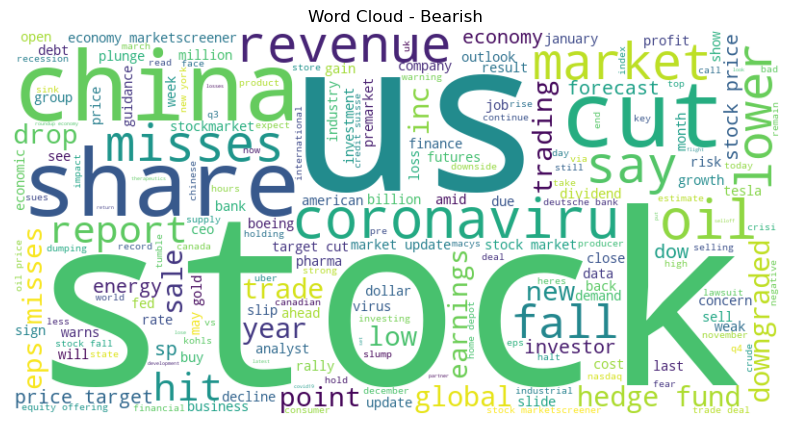

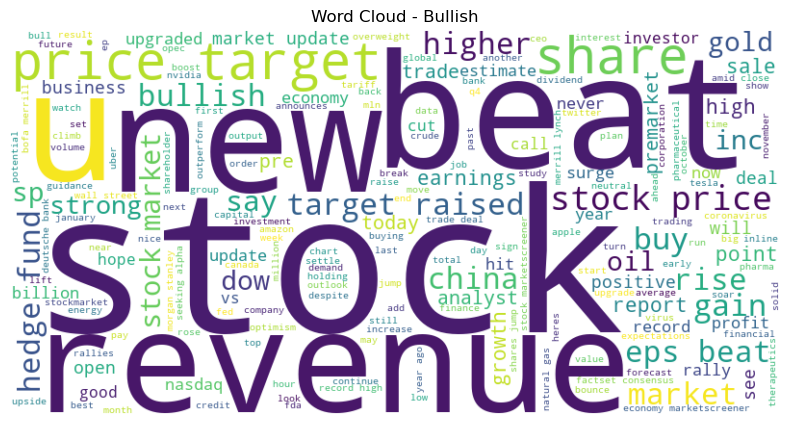

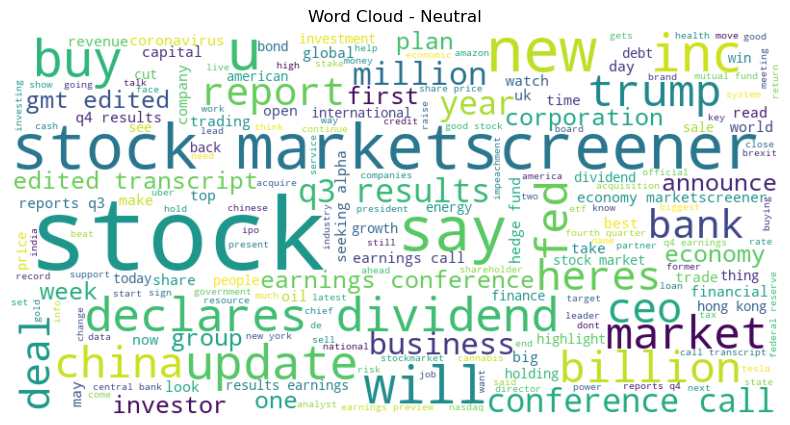

In [45]:
for label in [0, 1, 2]:
    subset = ds_train[ds_train["label"] == label]
    text = " ".join(subset["clean_text"])
    wc = WordCloud(width=800, height=400, background_color="white").generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud - {label_names[label]}")
    plt.show()


## 1.4 Tweets Length and Word Distribution 

If most tweets are short (less then 50 tokens), simpler models like BoW may be sufficient. If some are near the 280-char limit, LSTMs or BERT will be better.

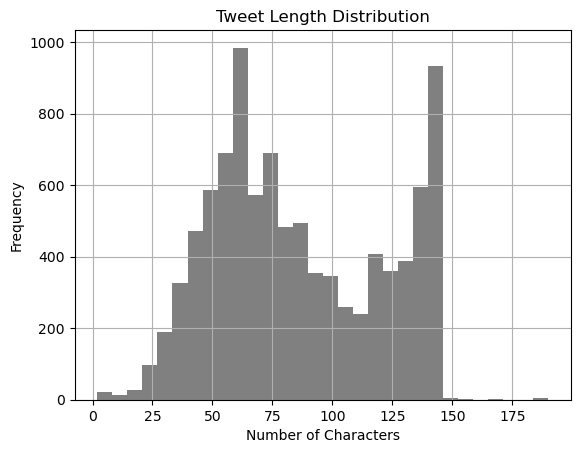

In [46]:
ds_train["text_length"] = ds_train["text"].apply(len)

plt.hist(ds_train["text_length"], bins=30, color="gray")
plt.title("Tweet Length Distribution")
plt.xlabel("Number of Characters")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

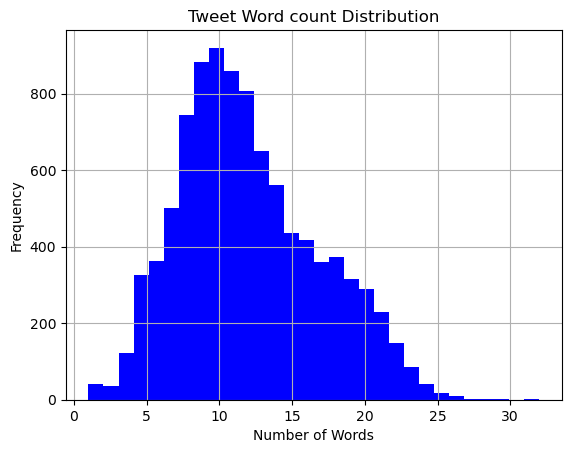

In [47]:
ds_train["text_words"] = ds_train["text"].apply(lambda x: len(x.split()))

plt.hist(ds_train["text_words"], bins=30, color="blue")
plt.title("Tweet Word count Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [48]:
# Apply to your DataFrame
ds_train["clean_text"] = ds_train["text"].apply(prjlib.preprocess)

# Peek at the results
ds_train[["text", "clean_text"]].head()

text  \
0  $BYND - JPMorgan reels in expectations on Beyo...   
1  $CCL $RCL - Nomura points to bookings weakness...   
2  $CX - Cemex cut at Credit Suisse, J.P. Morgan ...   
3  $ESS: BTIG Research cuts to Neutral https://t....   
4  $FNKO - Funko slides after Piper Jaffray PT cu...   

                                          clean_text  
0       ticker jpmorgan reel expectation beyond meat  
1  ticker ticker nomura point booking weakness ca...  
2  ticker cemex cut credit suisse jp morgan weak ...  
3                   ticker btig research cut neutral  
4            ticker funko slide piper jaffray pt cut